**Executed:** Mon Oct  3 17:07:30 2016

**Duration:** 32 seconds.

# Analysis of 5 smFRET samples

In this notebook:

* Per-sample FRET histograms
* Collapsed (merged channels) FRET histograms
* FRET vs distance plot (multi-spot vs usALEX)
* D-only fraction plots
* Burst size vs measurement (corrected and uncorrected)
* Background (per CH) vs measuremets
* Burst-per-second (per CH) vs measuremet
* Burst accumulation vs time (per CH and all-CH)

> **USAGE TIP**: to comment-out a code cell, select all (CTRL+a) and hit CTRL+/.

## FRET fitting remarks

In this notebook we fit the Proximity Ratio histogram using different models.

## Load FRETBursts software

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import os
import pandas as pd
from IPython.display import display
from IPython.display import display, Math

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

In [4]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5


## 8-spot paper plot style

In [5]:
PLOT_DIR = './figure/'

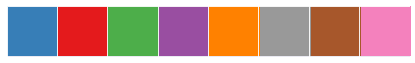

In [6]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

## Data files

Data folder:

In [7]:
data_dir = './data/multispot/'

Check that the folder exists:

In [8]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files in `data_dir`:

In [9]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))

In [10]:
labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/12d_New_30p_320mW_steer_3.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/17d_100p_320mW_steer_1.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/22d_30p_320mW_steer_1.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/27d_50p_320mW_steer_1.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/7d_New_150p_320mW_steer_3.hdf5',
 'DO': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/DO12_No2_50p_320mW_steer_1.hdf5'}

## Parameters from file

Load the **leakage coefficient** from disk (computed in [Multi-spot 5-Samples analyis - Leakage coefficient fit](Multi-spot 5-Samples analyis - Leakage coefficient fit.ipynb)):

In [11]:
leakage_coeff_fname = 'results/Multi-spot - leakage coefficient KDE wmean Dem.csv'
leakage = np.loadtxt(leakage_coeff_fname, ndmin=1)

print('Leakage coefficient:', leakage)

Leakage coefficient: [ 0.0334]


Load the **direct excitation coefficient** ($d_{dirT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [12]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_t beta.csv'
dir_ex_t = np.loadtxt(dir_ex_coeff_fname, ndmin=1)

print('Direct excitation coefficient (dir_ex_t):', dir_ex_t)

Direct excitation coefficient (dir_ex_t): [ 0.04932]


## Parameters

Analysis parameters:

In [13]:
gamma_pre = 1.       # Applied before FRET fit (used to correct burst data)
gamma_post = 0.44    # Applied after FRET fit (used to correct fitted E)
gamma_fit = 0.44     # Used to compute burst weights for the fit
gamma_sel = 0.44     # Used to compute burst size during burst selection
donor_ref = False    # False -> gamma correction is: g*nd + na
                     # True  -> gamma correction is: nd + na/g

hist_weights = 'size'

## Background fit parameters
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,
                 )

## Burst search
F=6
dither = False
size_th = 30    # Burst size threshold (selection on corrected burst sizes)

## FRET fit parameters
bandwidth = 0.03        # KDE bandwidth
E_range = {'7d':  (0.7, 1.0), '12d': (0.4, 0.8), '17d': (0.2, 0.4), 
           '22d': (0.0, 0.1), '27d': (0.0, 0.1), 'DO': (0.0, 0.1)}
E_axis_kde = np.arange(-0.2, 1.2, 0.0002)

Processing and plot options:

In [14]:
# Data load options
reload_data = 1
burst_search = 1
delete_ph_times = 0

# Per-sample plots
bg_plot = 0          # Plot background vs time, ph_times are needed
timetrace_plot = 0   # Plot timetrace, ph_times are needed
fret_plot = 1        # Plot FRET histograms

# All-samples plots
fret_dist_plot = 1
deviance_plot = 1

# Plot output options
save_figure = 0
nosuptitle = False

plt.rc('savefig', dpi=75)  # Changes the figure size in the notebook
savefig_kwargs =  dict(dpi=200, bbox_inches='tight')  # default save-figure options

fret_plot_kw = dict(bins = np.r_[-0.2:1.201:bandwidth],
                    fit_color='k', fit_alpha=0.9, fit_lw=2, #fit_fillcolor='#888888',
                    sharey = False)

In [15]:
# Make sure there is no error in the gamma definitions
assert ((gamma_pre == 1) and (gamma_post == gamma_fit)) or \
       ((gamma_post == 1) and (gamma_pre == gamma_fit))

## Utility functions

In [16]:
def print_fit_report(E_pr, gamma=1, leakage=0, dir_ex_t=0, math=True):
    """Print fit and standard deviation for both corrected and uncorrected E
    Returns d.E_fit.
    """
    E_corr = fretmath.correct_E_gamma_leak_dir(E_pr, gamma=gamma, leakage=leakage, dir_ex_t=dir_ex_t)
    
    E_pr_mean = E_pr.mean()*100
    E_pr_delta = (E_pr.max() - E_pr.min())*100
    
    E_corr_mean = E_corr.mean()*100
    E_corr_delta = (E_corr.max() - E_corr.min())*100
    if math:
        display(Math(r'\text{Pre}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_pr_mean, E_pr_delta)))
        display(Math(r'\text{Post}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_corr_mean, E_corr_delta)))
    else:
        print('Pre-gamma  E (delta, mean):  %.2f  %.2f' % (E_pr_mean, E_pr_delta))
        print('Post-gamma E (delta, mean):  %.2f  %.2f' % (E_corr_mean, E_corr_delta))

# 5-samples processing

In [17]:
df = pd.DataFrame(index=['7d', '12d', '17d', '22d', '27d'], columns=range(8))
df.index.name = 'Sample'
df.columns.name = 'Channel'

E_pr_fret = df.copy()
E_pr_fret_sig = df.copy()
nbursts = df.copy()

## 7bp sample

In [18]:
data_id = '7d'
if reload_data:
    d7 = loader.photon_hdf5(files_dict[data_id])
    d7.calc_bg(**bg_kwargs_auto)
if burst_search:
    d7.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d7.delete('ph_times_m')

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [19]:
gamma_sel

0.44

In [20]:
dfs7 = Sel(d7, select_bursts.size, th1=30, gamma=gamma_sel, donor_ref=donor_ref)
dx = dfs7

In [21]:
ds = Sel(dx, select_bursts.E, E1=0.2, E2=0.6)
ds.num_bursts

array([ 44,  31,  82, 135, 106,  50, 165, 165])

In [22]:
#dsf = ds.fuse_bursts(ms=2)

In [23]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=True, p2_center=0.8)
fitter.fit_histogram()

In [24]:
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.866766,0.872245,0.838805,0.84337,0.835858,0.858535,0.84036,0.846814


<IPython.core.display.Math object>

<IPython.core.display.Math object>

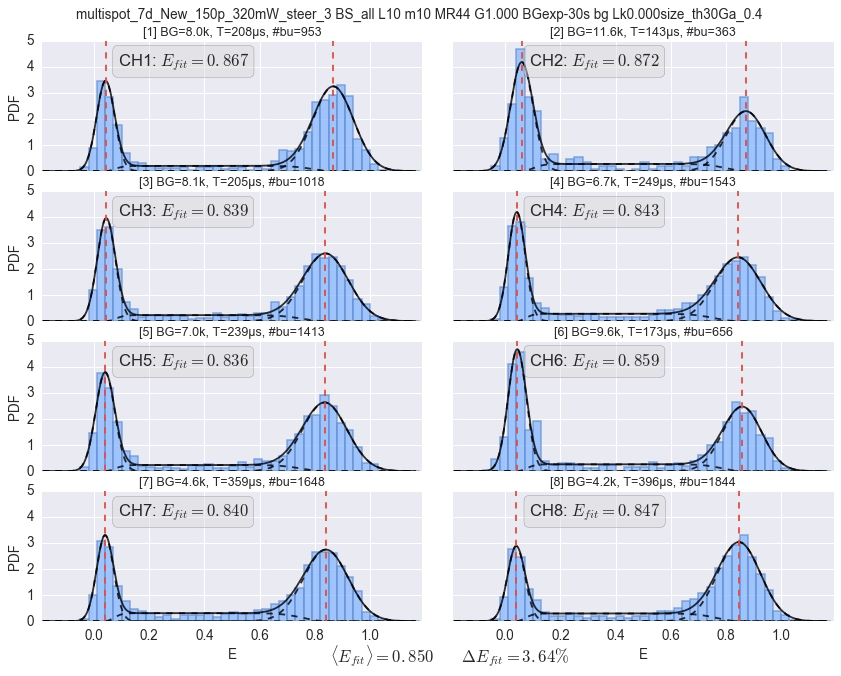

In [25]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

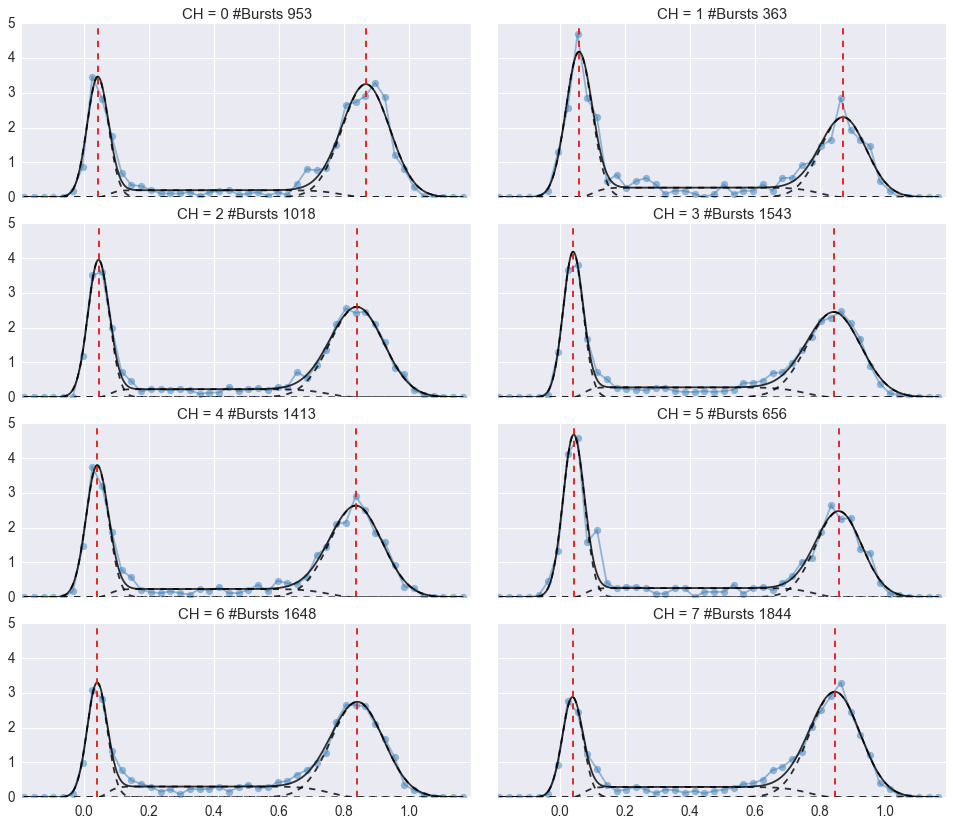

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.15)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(fitter, ich=ich, ax=ax)

## Compare the effect of burst-size weights

In [27]:
# bext.bursts_fitter(dx, weights=None)
# dx.E_fitter.fit_histogram(mfit.factory_two_gaussians())
# dplot(dx, hist_fret, weights=None, show_model=True, show_fit_stats=True, fit_from='p2_center');
# ylim(0, 6)
# fig_no_w = gcf()
# plt.close(fig_no_w)

# bext.bursts_fitter(dx, weights='size', gamma=0.43)
# dx.E_fitter.fit_histogram(mfit.factory_two_gaussians())
# dplot(dx, hist_fret, weights='size', gamma=0.43,
#       show_model=True, show_fit_stats=True, fit_from='p2_center');
# fig_w = gcf()
# plt.close(fig_w)

# def _plot(weights=False):
#     if weights:
#         display(fig_w)
#     else:
#         display(fig_no_w)

# interact(_plot, weights=False);

## 12bp sample

In [28]:
data_id = '12d'
if reload_data: 
    d12 = loader.photon_hdf5(files_dict[data_id])
    d12.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d12.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d12.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [29]:
dfs12 = Sel(d12, select_bursts.size, th1=30, gamma=gamma_sel, donor_ref=donor_ref)
dx = dfs12

In [30]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=True, p2_center=0.65)
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
12d,0.58912,0.580325,0.572867,0.574415,0.563134,0.555029,0.565811,0.563246


<IPython.core.display.Math object>

<IPython.core.display.Math object>

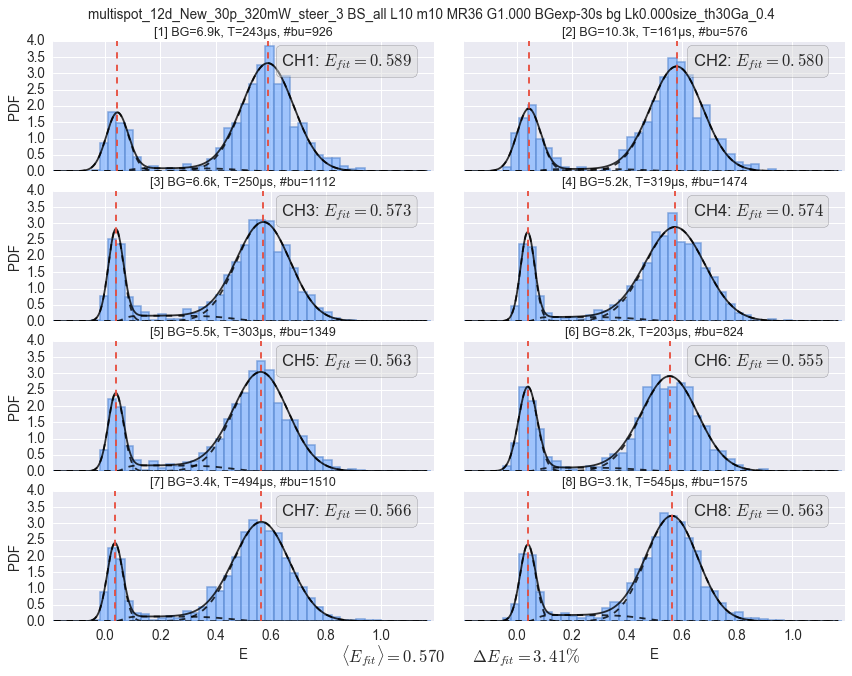

In [31]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

## 17bp sample

In [32]:
data_id = '17d'
if reload_data:
    d17 = loader.photon_hdf5(files_dict[data_id])
    d17.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d17.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d17.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [33]:
dfs17 = Sel(d17, select_bursts.size, th1=30, gamma=gamma_sel, donor_ref=donor_ref)
dx = dfs17

In [34]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=False, p2_center=0.4)
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
17d,0.297846,0.287886,0.276148,0.279504,0.283104,0.284872,0.271156,0.271861


<IPython.core.display.Math object>

<IPython.core.display.Math object>

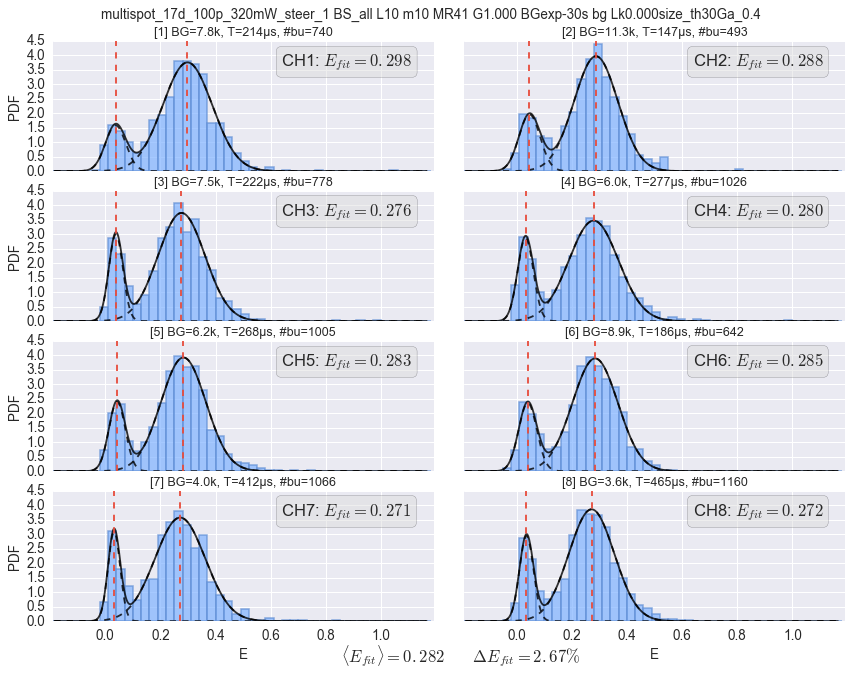

In [35]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

## 22bp sample

In [36]:
data_id = '22d'
if reload_data:
    d22 = loader.photon_hdf5(files_dict[data_id])
    d22.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d22.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d22.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [37]:
dfs22 = Sel(d22, select_bursts.size, th1=30, gamma=gamma_sel, donor_ref=donor_ref)
dx = dfs22

In [38]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
22d,0.133968,0.131691,0.124933,0.126694,0.119514,0.124942,0.122458,0.12983


<IPython.core.display.Math object>

<IPython.core.display.Math object>

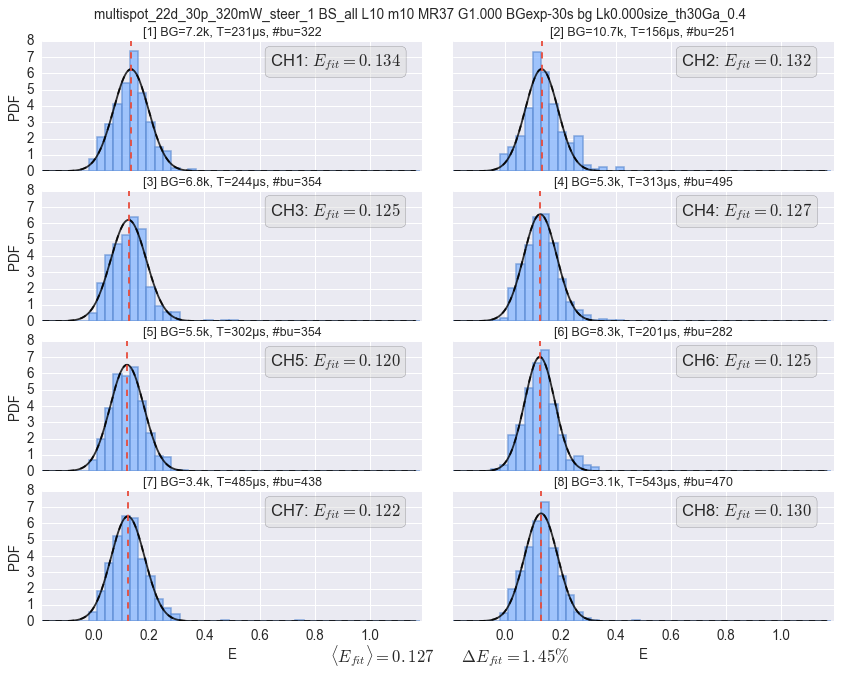

In [39]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

## 27bp sample

In [40]:
data_id = '27d'
if reload_data:
    d27 = loader.photon_hdf5(files_dict[data_id])
    d27.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d27.burst_search(m=10, F=F, dither=dither)#, ph_sel=Ph_sel(Dex='Dem'))
    if delete_ph_times: d27.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [41]:
dfs27 = Sel(d27, select_bursts.size, th1=30, gamma=gamma_sel, donor_ref=donor_ref)
dx = dfs27

In [42]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_asym_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
27d,0.0788739,0.0739951,0.0731221,0.0793372,0.0718892,0.0738369,0.0732605,0.0810806


<IPython.core.display.Math object>

<IPython.core.display.Math object>

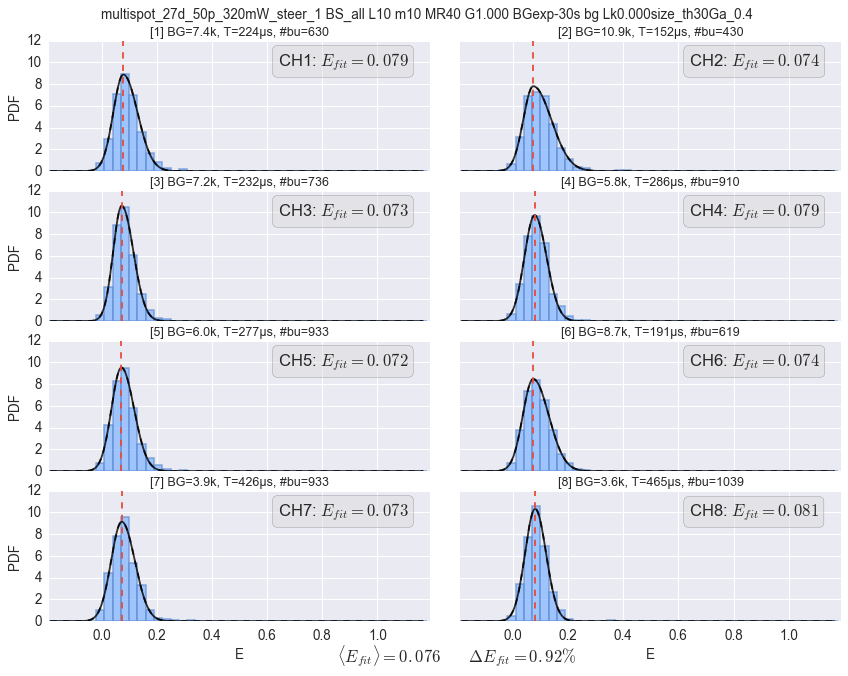

In [43]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

In [44]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
27d,0.0871833,0.0913123,0.0791241,0.0826804,0.0771643,0.0845735,0.0779233,0.0826383


<IPython.core.display.Math object>

<IPython.core.display.Math object>

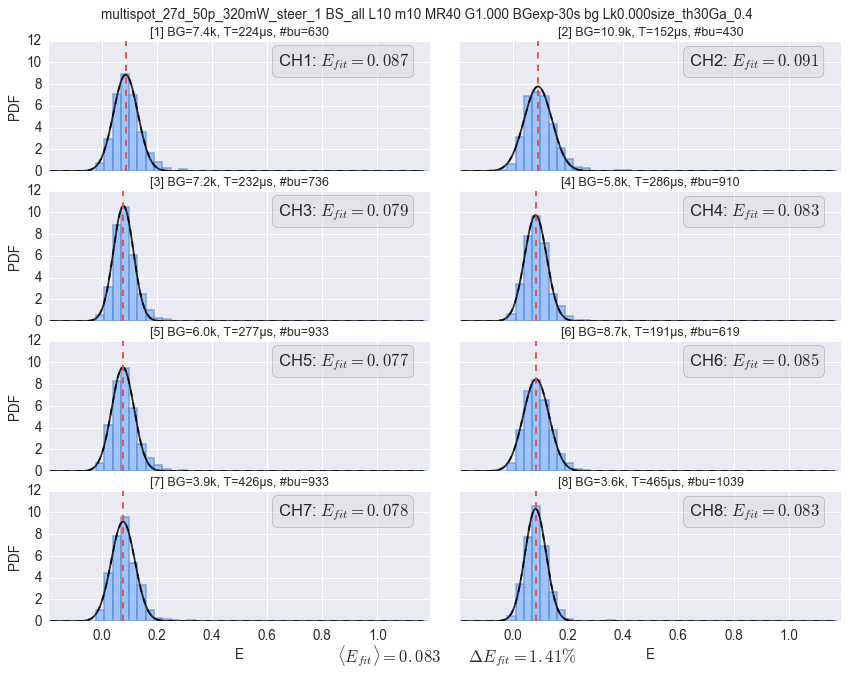

In [45]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

## 5-samples: global analysis

Proximity ratios fitted from multispot data:

In [46]:
E_pr_fret

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.866766,0.872245,0.838805,0.84337,0.835858,0.858535,0.84036,0.846814
12d,0.58912,0.580325,0.572867,0.574415,0.563134,0.555029,0.565811,0.563246
17d,0.297846,0.287886,0.276148,0.279504,0.283104,0.284872,0.271156,0.271861
22d,0.133968,0.131691,0.124933,0.126694,0.119514,0.124942,0.122458,0.12983
27d,0.0871833,0.0913123,0.0791241,0.0826804,0.0771643,0.0845735,0.0779233,0.0826383


In [47]:
E_pr_fret.to_csv('results/Multi-spot - dsDNA - PR - all_samples all_ch.csv')

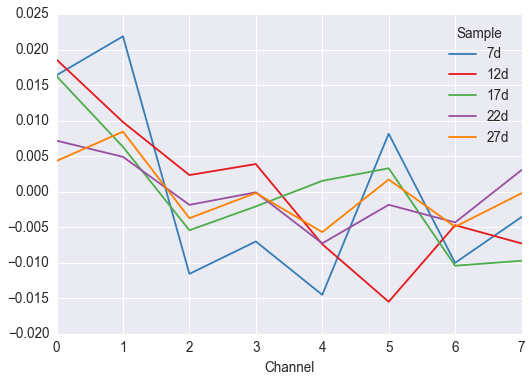

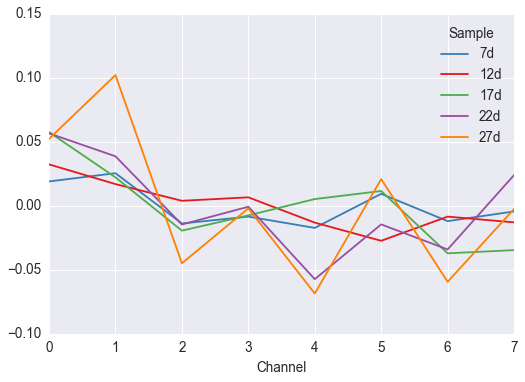

In [48]:
norm = (E_pr_fret.T - E_pr_fret.mean(1))#/E_pr_fret.mean(1)
norm_rel = (E_pr_fret.T - E_pr_fret.mean(1))/E_pr_fret.mean(1)
norm.plot()
norm_rel.plot()

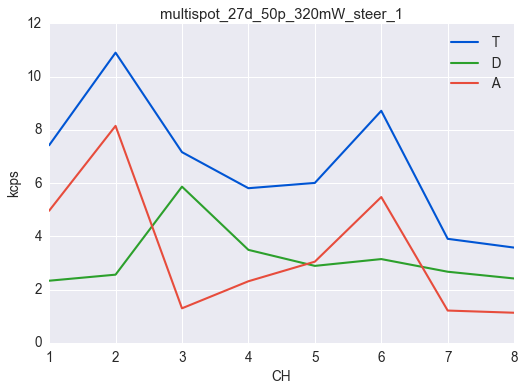

In [49]:
mch_plot_bg(dx)

> **NOTE:** The 27d and DO samples have a trend that correlates with the A-ch background. For these samples could be beneficial to use a D-only burst search.

> **NOTE 2**: Like observed during the leakage fit, even a D-only burst search results in +2% offset (DO) in CH1, this cannot be correlation with the A-background and must be slightly different gamma in the spot.

Corrected $E$ from μs-ALEX data:

In [50]:
data_file = 'results/usALEX-5samples-E-corrected-all-ph.csv'
data_alex = pd.read_csv(data_file).set_index('sample')#[['E_pr_fret_kde']]
data_alex.round(6)

,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,nt_mean
sample,,,,,,,,,,,,,
7d,1172,587,542,0.9290,0.924307,0.060130,0.002583,0.5520,0.550744,0.099172,0.004260,0.0022,22.227823
12d,1307,329,948,0.7398,0.727043,0.092062,0.002990,0.5758,0.558745,0.105387,0.003423,0.0154,22.002399
17d,2489,464,1964,0.4268,0.422624,0.112952,0.002549,0.5462,0.539604,0.112457,0.002538,0.0124,21.193171
22d,2054,320,1672,0.1774,0.181067,0.077181,0.001888,0.5458,0.547034,0.114990,0.002812,0.0000,23.016538
27d,791,160,589,0.0826,0.083971,0.069304,0.002856,0.5208,0.561290,0.114456,0.004716,-0.0088,16.830070


In [51]:
E_alex = data_alex.E_gauss_w
E_alex

sample
7d     0.924307
12d    0.727043
17d    0.422624
22d    0.181067
27d    0.083971
Name: E_gauss_w, dtype: float64

## Merging the channels

Merge the data of the different channels:

In [52]:
dfs7c = dfs7.collapse()
dfs12c = dfs12.collapse()
dfs17c = dfs17.collapse()
dfs22c = dfs22.collapse()
dfs27c = dfs27.collapse()

## Define samples lists

Define list of results and labels:

In [53]:
d_samples = [dfs7, dfs12, dfs17, dfs22, dfs27]#, dfso]
d_samples_c = [dfs7c, dfs12c, dfs17c, dfs22c, dfs27c ]
d_labels = ['7d', '12d', '17d', '22d', '27d']#, 'DO']
CH = np.arange(8)
CH_labels = ['CH%d' % i for i in CH]
dist_s_bp = [7, 12, 17, 22, 27]

Print a summary of current processed data:

In [54]:
def print_params(d_samples, d_labels, status=False):
    print('Sample              Model             Ph_sel')
    for dx, name in zip(d_samples, d_labels):
        print("%3s %25s %35s" % (name, dx.E_fitter.model.name, dx.ph_sel))
    if status:
        print()
        for dx, name in zip(d_samples, d_labels):
            print(dx.status())

In [55]:
print_params(d_samples, d_labels, 1)

Sample              Model             Ph_sel
 7d ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))                                 all
12d ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))                                 all
17d (Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_'))                                 all
22d           Model(gaussian)                                 all
27d           Model(gaussian)                                 all

multispot_7d_New_150p_320mW_steer_3 BS_all L10 m10 MR44 G1.000 BGexp-30s bg Lk0.000size_th30Ga_0.4
multispot_12d_New_30p_320mW_steer_3 BS_all L10 m10 MR36 G1.000 BGexp-30s bg Lk0.000size_th30Ga_0.4
multispot_17d_100p_320mW_steer_1 BS_all L10 m10 MR41 G1.000 BGexp-30s bg Lk0.000size_th30Ga_0.4
multispot_22d_30p_320mW_steer_1 BS_all L10 m10 MR37 G1.000 BGexp-30s bg Lk0.000size_th30Ga_0.4
multispot_27d_50p_320mW_steer_1 BS_all 

### Plot FRET vs distance